In [53]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
import sklearn
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from datetime import datetime
from datetime import timedelta
import pickle

In [2]:
employee_survey_df = pd.read_csv("employee_survey_data.csv")
print(employee_survey_df.shape)
print(employee_survey_df.info())

(4410, 4)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4410 entries, 0 to 4409
Data columns (total 4 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   EmployeeID               4410 non-null   int64  
 1   EnvironmentSatisfaction  4385 non-null   float64
 2   JobSatisfaction          4390 non-null   float64
 3   WorkLifeBalance          4372 non-null   float64
dtypes: float64(3), int64(1)
memory usage: 137.9 KB
None


In [3]:
general_data = pd.read_csv("general_data.csv")
print(general_data.shape)
print(general_data.info())

(4410, 24)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4410 entries, 0 to 4409
Data columns (total 24 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Age                      4410 non-null   int64  
 1   Attrition                4410 non-null   object 
 2   BusinessTravel           4410 non-null   object 
 3   Department               4410 non-null   object 
 4   DistanceFromHome         4410 non-null   int64  
 5   Education                4410 non-null   int64  
 6   EducationField           4410 non-null   object 
 7   EmployeeCount            4410 non-null   int64  
 8   EmployeeID               4410 non-null   int64  
 9   Gender                   4410 non-null   object 
 10  JobLevel                 4410 non-null   int64  
 11  JobRole                  4410 non-null   object 
 12  MaritalStatus            4410 non-null   object 
 13  MonthlyIncome            4410 non-null   int64  
 14  NumCompaniesW

In [4]:
manager_data_df = pd.read_csv("manager_survey_data.csv")
print(manager_data_df.shape)
print(manager_data_df.info())

(4410, 3)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4410 entries, 0 to 4409
Data columns (total 3 columns):
 #   Column             Non-Null Count  Dtype
---  ------             --------------  -----
 0   EmployeeID         4410 non-null   int64
 1   JobInvolvement     4410 non-null   int64
 2   PerformanceRating  4410 non-null   int64
dtypes: int64(3)
memory usage: 103.5 KB
None


In [49]:
in_time_df = pd.read_csv("in_time.csv")
in_time_df.insert(1, "EmployeeID", in_time_df["Unnamed: 0"] )
in_time_df= in_time_df.drop(columns=["Unnamed: 0"] )
out_time_df = pd.read_csv("out_time.csv")
out_time_df.insert(1, "EmployeeID", out_time_df["Unnamed: 0"] )
out_time_df= out_time_df.drop(columns=["Unnamed: 0"] )

In [51]:
#Drops all the date columns which are completely null and
#Fill mode to those columns which have some null values

size = in_time_df.shape[0];
for column in in_time_df:
    #Drops the column if the whole column is null (incase of holidays)
    drop = 1 if(in_time_df[column].isnull().sum()==size) else 0
    drop2 = 1 if(out_time_df[column].isnull().sum()==size) else 0
    
    if(drop == 1):
        in_time_df = in_time_df.drop(columns = column)
    if(drop2 == 1):
        out_time_df = out_time_df.drop(columns = column)
        
    elif column != "EmployeeID":
        #Converting object dataframe column to datetime
        in_time_df[column] = pd.to_datetime(in_time_df[column])
        out_time_df[column] = pd.to_datetime(out_time_df[column])
        
        #filling na with mode
        in_time_df[column] = in_time_df[column].fillna(pd.to_datetime(in_time_df[column].mode()[0]))
        out_time_df[column] = out_time_df[column].fillna(pd.to_datetime(out_time_df[column].mode()[0]))        

In [60]:
#Subtracting in time and out time in order to find total working hours
in_time_df_temp = in_time_df.drop(columns="EmployeeID").copy()
out_time_df_temp = out_time_df.drop(columns="EmployeeID").copy()
time_diff = out_time_df_temp - in_time_df_temp
for column in time_diff:
    if(column!= "EmployeeID"):
        time_diff[column] = time_diff[column]/timedelta(hours=1)
time_diff["EmployeeID"] = in_time_df["EmployeeID"]

In [61]:
time_diff.head()

,2015-01-02,2015-01-05,2015-01-06,2015-01-07,2015-01-08,2015-01-09,2015-01-12,2015-01-13,2015-01-15,2015-01-16,...,2015-12-18,2015-12-21,2015-12-22,2015-12-23,2015-12-24,2015-12-28,2015-12-29,2015-12-30,2015-12-31,EmployeeID
0,7.208333,7.189722,7.410833,7.006667,7.289722,7.484444,7.262778,7.831111,7.346944,7.267500,...,6.900000,7.339167,7.395833,6.504722,7.596389,7.773889,7.315000,7.778889,7.080278,1
1,8.109167,7.454722,6.697222,7.396944,7.416667,7.150833,7.611389,7.278889,7.613056,7.727500,...,7.903056,7.753889,7.712222,7.435556,5.978889,7.614722,7.982500,7.986111,8.227222,2
2,6.692500,7.265556,6.405278,6.765000,7.345000,6.861389,7.418611,6.999722,7.438333,7.210278,...,6.785833,7.163611,6.801667,6.730278,6.849722,7.023889,7.438889,7.538889,6.786389,3
3,7.338333,7.291944,6.943056,6.919444,6.850833,7.193056,6.998611,7.306389,6.876667,6.907778,...,7.629167,6.846667,7.326389,7.413611,7.085000,7.447222,7.416667,7.366389,7.133056,4
4,8.055556,7.988056,7.682500,7.806111,7.662222,7.721667,8.365000,8.257222,8.260000,8.403611,...,7.903611,7.665000,7.957500,7.786944,8.249444,7.662222,8.268611,7.953333,8.018056,5


In [68]:
#Merging all the DF into one DF
combinedData = employee_survey_df.merge(general_data, left_on="EmployeeID", right_on="EmployeeID", how="inner")
combinedData = combinedData.merge(manager_data_df, left_on="EmployeeID", right_on="EmployeeID", how="inner")
#Changing Attrition to 0 and 1 because this is the label
combinedData['Attrition'] = combinedData['Attrition'].map({'Yes': 1, 'No': 0})
combinedData.head()

,EmployeeID,EnvironmentSatisfaction,JobSatisfaction,WorkLifeBalance,Age,Attrition,BusinessTravel,Department,DistanceFromHome,Education,...,PercentSalaryHike,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,YearsAtCompany,YearsSinceLastPromotion,YearsWithCurrManager,JobInvolvement,PerformanceRating
0,1,3.0,4.0,2.0,51,0,Travel_Rarely,Sales,6,2,...,11,8,0,1.0,6,1,0,0,3,3
1,2,3.0,2.0,4.0,31,1,Travel_Frequently,Research & Development,10,1,...,23,8,1,6.0,3,5,1,4,2,4
2,3,2.0,2.0,1.0,32,0,Travel_Frequently,Research & Development,17,4,...,15,8,3,5.0,2,5,0,3,3,3
3,4,4.0,4.0,3.0,38,0,Non-Travel,Research & Development,2,5,...,11,8,3,13.0,5,8,7,5,2,3
4,5,4.0,1.0,3.0,32,0,Travel_Rarely,Research & Development,10,1,...,12,8,2,9.0,2,6,0,4,3,3


In [69]:
combinedData.isnull().sum()

EmployeeID                  0
EnvironmentSatisfaction    25
JobSatisfaction            20
WorkLifeBalance            38
Age                         0
Attrition                   0
BusinessTravel              0
Department                  0
DistanceFromHome            0
Education                   0
EducationField              0
EmployeeCount               0
Gender                      0
JobLevel                    0
JobRole                     0
MaritalStatus               0
MonthlyIncome               0
NumCompaniesWorked         19
Over18                      0
PercentSalaryHike           0
StandardHours               0
StockOptionLevel            0
TotalWorkingYears           9
TrainingTimesLastYear       0
YearsAtCompany              0
YearsSinceLastPromotion     0
YearsWithCurrManager        0
JobInvolvement              0
PerformanceRating           0
dtype: int64

In [70]:
#Filling null values will median
combinedData["EnvironmentSatisfaction"] = combinedData["EnvironmentSatisfaction"].fillna(combinedData["EnvironmentSatisfaction"].median())
combinedData["JobSatisfaction"] = combinedData["JobSatisfaction"].fillna(combinedData["JobSatisfaction"].median())
combinedData["WorkLifeBalance"] = combinedData["WorkLifeBalance"].fillna(combinedData["WorkLifeBalance"].median())
combinedData["NumCompaniesWorked"] = combinedData["NumCompaniesWorked"].fillna(combinedData["NumCompaniesWorked"].median())
combinedData["TotalWorkingYears"] = combinedData["TotalWorkingYears"].fillna(combinedData["TotalWorkingYears"].median())

<AxesSubplot:>

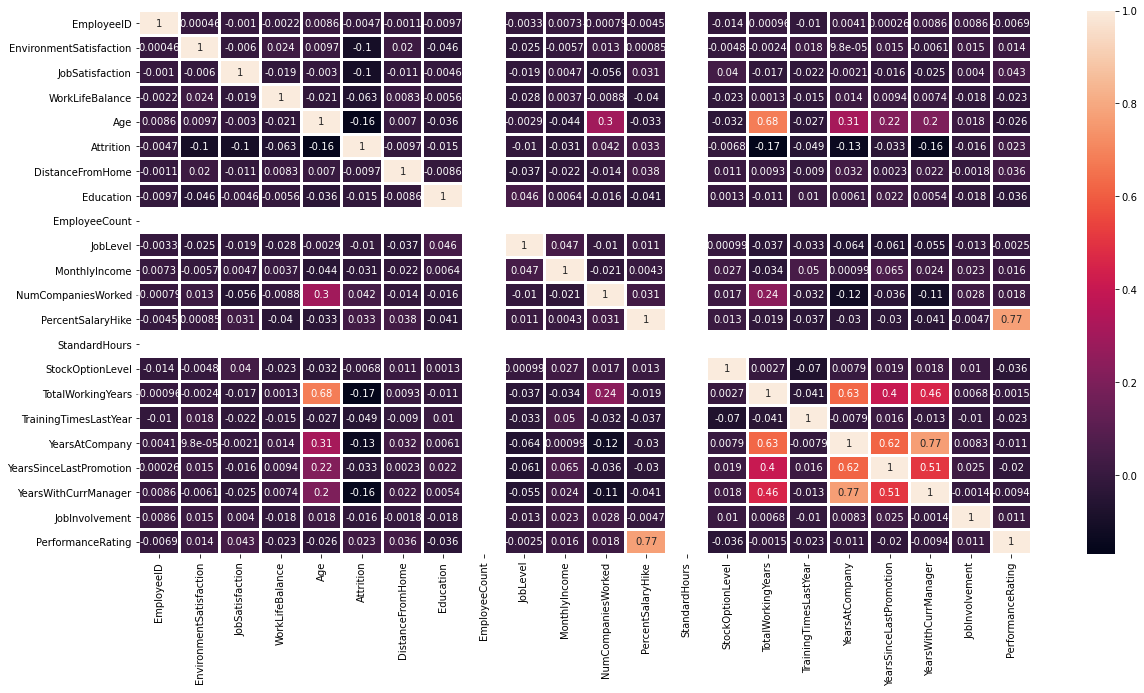

In [71]:
corr = combinedData.corr()
plt.figure(figsize= (20,10))
sns.heatmap(corr, 
            xticklabels=corr.columns, yticklabels=corr.columns, linewidths=2, annot=True)

In [72]:
combinedData = combinedData.merge(time_diff, left_on="EmployeeID", right_on="EmployeeID", how="inner")

In [73]:
#Dropping various highly correlated columns and useless columns
cleanDf = combinedData.drop(columns=["EmployeeID","Over18" ,"PercentSalaryHike", "Age", "YearsAtCompany", "StandardHours", "EducationField", "Education", "EmployeeCount", "Gender", "MonthlyIncome"])

In [74]:
#data sacaling (normalizing)
def normalize_data(df):
    min_max_scaler = sklearn.preprocessing.MinMaxScaler()
    df["DistanceFromHome"] = min_max_scaler.fit_transform(df["DistanceFromHome"].values.reshape(-1,1))
    return df
normalize_data(cleanDf)

,EnvironmentSatisfaction,JobSatisfaction,WorkLifeBalance,Attrition,BusinessTravel,Department,DistanceFromHome,JobLevel,JobRole,MaritalStatus,...,2015-12-17,2015-12-18,2015-12-21,2015-12-22,2015-12-23,2015-12-24,2015-12-28,2015-12-29,2015-12-30,2015-12-31
0,3.0,4.0,2.0,0,Travel_Rarely,Sales,0.178571,1,Healthcare Representative,Married,...,6.186389,6.900000,7.339167,7.395833,6.504722,7.596389,7.773889,7.315000,7.778889,7.080278
1,3.0,2.0,4.0,1,Travel_Frequently,Research & Development,0.321429,1,Research Scientist,Single,...,7.928333,7.903056,7.753889,7.712222,7.435556,5.978889,7.614722,7.982500,7.986111,8.227222
2,2.0,2.0,1.0,0,Travel_Frequently,Research & Development,0.571429,4,Sales Executive,Married,...,7.218333,6.785833,7.163611,6.801667,6.730278,6.849722,7.023889,7.438889,7.538889,6.786389
3,4.0,4.0,3.0,0,Non-Travel,Research & Development,0.035714,3,Human Resources,Married,...,7.455833,7.629167,6.846667,7.326389,7.413611,7.085000,7.447222,7.416667,7.366389,7.133056
4,4.0,1.0,3.0,0,Travel_Rarely,Research & Development,0.321429,1,Sales Executive,Single,...,8.320000,7.903611,7.665000,7.957500,7.786944,8.249444,7.662222,8.268611,7.953333,8.018056
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4405,4.0,1.0,3.0,0,Travel_Rarely,Research & Development,0.142857,1,Research Scientist,Single,...,8.504722,8.083056,8.161389,8.292500,8.604444,8.596944,8.482222,9.074722,8.943611,8.508056
4406,4.0,4.0,3.0,0,Travel_Rarely,Research & Development,0.035714,1,Laboratory Technician,Divorced,...,5.983611,5.925000,5.830556,5.924722,6.110556,5.992778,5.669722,6.558333,5.702222,6.147500
4407,1.0,3.0,3.0,0,Travel_Rarely,Research & Development,0.857143,2,Sales Executive,Married,...,7.685278,7.785556,7.866111,7.753611,7.752222,7.401944,7.734444,7.705278,7.760556,8.090278
4408,4.0,1.0,3.0,0,Travel_Rarely,Sales,0.607143,1,Laboratory Technician,Divorced,...,9.255000,9.969722,9.340833,9.372500,9.241667,9.697778,10.053056,9.012222,9.360556,9.616111


In [75]:
#Handeling categorical data
cleanDf = pd.get_dummies(cleanDf, columns=["Department", "JobRole", "BusinessTravel", "MaritalStatus"])

In [76]:
X = cleanDf.drop(columns = ['Attrition']).copy()
y = cleanDf['Attrition']
print(X.shape)
print(y.shape)

(4410, 280)
(4410,)


In [77]:
X_train, X_rem, y_train, y_rem = train_test_split(X,y, train_size=0.7, random_state = 100, stratify=y)
X_valid, X_test, y_valid, y_test = train_test_split(X_rem,y_rem, test_size=0.5, random_state = 100, stratify=y_rem)
print(X_train.shape), print(y_train.shape)
print(X_rem.shape), print(y_rem.shape)
print(X_valid.shape), print(y_valid.shape)
print(X_test.shape), print(y_test.shape)

(3087, 280)
(3087,)
(1323, 280)
(1323,)
(661, 280)
(661,)
(662, 280)
(662,)


(None, None)

In [112]:
x =np.arange(0.0, 100.1, 0.1)
# x = [0.001, 0.01, 0.1, 1, 10, 100, 1000]
print(x)

[  0.    0.1   0.2 ...  99.8  99.9 100. ]


In [113]:
#Finding best hyperparameters using GridSearchCV
import warnings
warnings.filterwarnings('ignore')
logreg = LogisticRegression()
grid={"C": x, "penalty":["l1","l2"]}
clf = GridSearchCV(logreg, grid,cv=10)
clf.fit(X_train, y_train)

GridSearchCV(cv=10, estimator=LogisticRegression(),
             param_grid={'C': array([  0. ,   0.1,   0.2, ...,  99.8,  99.9, 100. ]),
                         'penalty': ['l1', 'l2']})

In [117]:
print("tuned hpyerparameters :(best parameters) ",clf.best_params_)
print("accuracy :",clf.best_score_)

tuned hpyerparameters :(best parameters)  {'C': 39.2, 'penalty': 'l2'}
accuracy : 0.8467711091497498


In [118]:
logreg = LogisticRegression(C=clf.best_params_["C"], penalty=clf.best_params_["penalty"]).fit(X_train,y_train)

In [119]:
y_train_pred = logreg.predict(X_train)
y_test_pred = logreg.predict(X_test)

In [120]:
print(classification_report(y_train,y_train_pred))

              precision    recall  f1-score   support

           0       0.89      0.98      0.93      2589
           1       0.76      0.40      0.52       498

    accuracy                           0.88      3087
   macro avg       0.83      0.69      0.73      3087
weighted avg       0.87      0.88      0.87      3087



In [121]:
print(classification_report(y_test,y_test_pred))

              precision    recall  f1-score   support

           0       0.88      0.95      0.91       555
           1       0.53      0.31      0.39       107

    accuracy                           0.84       662
   macro avg       0.70      0.63      0.65       662
weighted avg       0.82      0.84      0.83       662



In [122]:
print("Accuracy:")
print(metrics.accuracy_score(y_train, y_train_pred))
print(metrics.accuracy_score(y_test, y_test_pred))

Accuracy:
0.8830579850988014
0.8444108761329305


In [123]:
print("ROC AUC Score:")
print(metrics.roc_auc_score(y_train, y_train_pred))
print(metrics.roc_auc_score(y_test, y_test_pred))

ROC AUC Score:
0.6870145704486544
0.6280794813505093


In [124]:
train_confusion = metrics.confusion_matrix(y_train, y_train_pred)
train_TP = train_confusion[1, 1]
train_TN = train_confusion[0, 0]
train_FP = train_confusion[0, 1]
train_FN = train_confusion[1, 0]
print(train_confusion)

[[2528   61]
 [ 300  198]]


In [125]:
test_confusion = metrics.confusion_matrix(y_test, y_test_pred)
test_TP = test_confusion[1, 1]
test_TN = test_confusion[0, 0]
test_FP = test_confusion[0, 1]
test_FN = test_confusion[1, 0]
print(test_confusion)

[[526  29]
 [ 74  33]]


In [126]:
test_fpr, test_tpr, test_thresholds = metrics.roc_curve(y_test, y_test_pred)

No handles with labels found to put in legend.


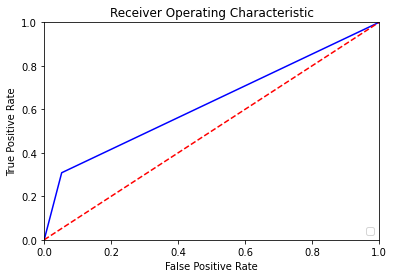

In [127]:
plt.title('Receiver Operating Characteristic')
plt.plot(test_fpr, test_tpr, 'b')
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [128]:
y_valid_pred = logreg.predict(X_valid)

In [129]:
print("Accuracy:")
print(metrics.accuracy_score(y_valid, y_valid_pred))
print("ROC AUC Score:")
print(metrics.roc_auc_score(y_valid, y_valid_pred))

Accuracy:
0.8381240544629349
ROC AUC Score:
0.6021332653408126


In [130]:
valid_confusion = metrics.confusion_matrix(y_valid, y_valid_pred)
valid_TP = train_confusion[1, 1]
valid_TN = train_confusion[0, 0]
valid_FP = train_confusion[0, 1]
valid_FN = train_confusion[1, 0]
print(valid_confusion)

[[527  28]
 [ 79  27]]


In [131]:
valid_fpr, valid_tpr, valid_thresholds = metrics.roc_curve(y_valid, y_valid_pred)

No handles with labels found to put in legend.


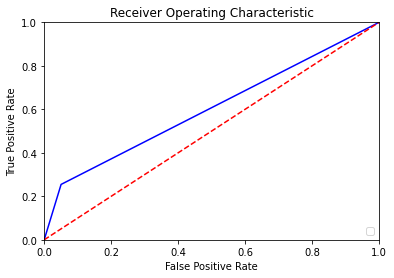

In [132]:
plt.title('Receiver Operating Characteristic')
plt.plot(valid_fpr, valid_tpr, 'b')
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [133]:
# save the model to disk
filename = 'hr_analytics.pkl'
pickle.dump(logreg, open(filename, 'wb'))

In [134]:
file = open("columnsRequired.txt", "w")
file.write(str(cleanDf.columns.values))
file.close()